In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import skimage 
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from skimage.io import imread_collection, imread
from skimage.io.collection import ImageCollection
import random
sns.set_style("whitegrid")

#### Make an encoder decoder to convert grayscale H&E to colored H&E

In [80]:

def list_files1(directory, extension):
    """
    list_files1: Find files with a certain extension in the directory and return the names in a list
            Args:
                directory: Directory to be searched
                extension: the extension of the files
            Returns:
                List of files with the extension within the directory
    """
    return list(( (directory + f) for f in listdir(directory) if f.endswith('.' + extension)))

def imread_grayscale(img_path):
    """
    imread_grayscale: Read images in lab
               Args:
                    img_path: Get the path of the image
               Returns:
                    Matrix with the image as a gray-scale
                
    """
    img = (1.0/255)*imread(img_path)
    return skimage.color.rgb2lab(img)

def load_from_dir(directory, extension):
    """
    load_from_dir: Takes in the directory path and extension of images to be read, and reads them in.
            Args:
                (String) directroy: path to directory
                (String) extension: extension of the files to be read
            Returns:
                (Numpy Array)data: The normal data w the 3 channels
                (Numpy Array) data_gray: the data converted to gray scale format 
    """
    data = np.array(ImageCollection('{a}/*.{b}'.format(a = directory, b = extension), load_func=imread))
    data_gray = np.array(ImageCollection('{a}/*.{b}'.format(a = directory, b = extension), load_func = imread_grayscale))
    return (data,data_gray)

### Plot a few points
def plt_predict(idx,X_HE,Y_HE, myModel, mode = 0):
    """
    plt_predict_HE: Plot the gray scale image, expected output and the color prediction by model
                Args:
                    (int) idx: index within X_HE that needs to be plotted
            (Numpy Array) X_HE: Data containing the colored image. Shape = (example_no, img_size, img_size,1)
            (Numpy Array) Y_HE: Data containg the color image. Shape = (example_no, img_size, img_size, 3)
            (keras Model) myModel: Model that is used for prediction
            (int) mode: 0 for H&E, 1 for MUSE
                Returns:
                        None
                    
    """
    img = X_HE[idx,:,:]
    
    pred = myModel.predict(img.reshape(1,512,512,1)).reshape(512,512,2)
    pred = (pred * 256)- 128
    pred = skimage.color.lab2rgb( np.concatenate((img,pred), axis =2 ))
    
    sns.set_style('whitegrid')
    plt.figure(figsize = (10,10))
    plt.subplot(1,3,1)
    plt.imshow(img.reshape(512,512), cmap = "gray")
    plt.title("Gray Scale Image(Input)")
    plt.subplot(1,3,2)
    plt.imshow(Y_HE[idx,:,:,:])
    if(mode==0):
        plt.title("Actual Color mapping for H&E(output)")
    if(mode ==1):
        plt.title("MUSE Image")
    plt.subplot(1,3,3)
    plt.imshow(pred)
    plt.title("Color prediction by model") 

In [3]:
### Resd in H&E Images
directory = "../datasets/MUSE/trainB"
extension = "png"
data, data_gray = load_from_dir(directory, extension)
print("Shape of data_gray is {}".format(data_gray.shape))
print("Shape of data is {}".format(data.shape))

Shape of data_gray is (334, 512, 512, 3)
Shape of data is (334, 512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


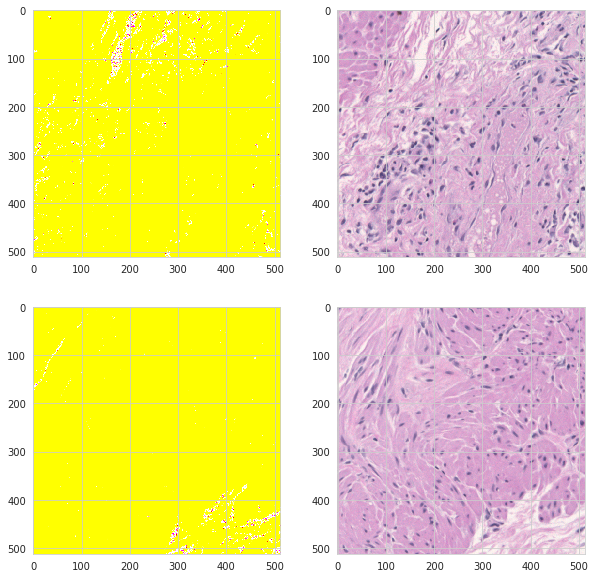

In [4]:
## Plot some random Images to see the gray scale and the colored version of them 
idx = random.randint(0,100)
idx1 = random.randint(0,100)
plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
plt.imshow(data_gray[idx,:,:], cmap = "gray")
plt.subplot(2,2,2)
plt.imshow(data[idx,:,:,:], cmap = "gray")
plt.subplot(2,2,3)
plt.imshow(data_gray[idx1,:,:], cmap = "gray")
plt.subplot(2,2,4)
plt.imshow(data[idx1,:,:,:], cmap = "gray")


In [63]:
#### Build the NN for GrayScale to Color mapping 
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPool2D, AveragePooling2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam


def define_model_1():
    #Design the neural network
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape = (512,512,1)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(2, (3, 3), activation='softmax', padding='same'))
    #model.add(Conv2D(2, (3, 3), padding='same'))
    opt = Adam(learning_rate = 0.001)
    model.add(UpSampling2D((2, 2)))
    model.compile(optimizer=opt, loss='mse', metrics = ['mae'])
    return(model)


In [64]:
## Generate Model and print out summary
myModel = define_model_1()
myModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 256, 256, 128)     73856     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 128, 128, 256)     295168    
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 256)       590080    
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 64, 64, 512)      

In [65]:
## Get data-> generate train and test data -> reshape it -> Scale it 

X_HE = data_gray[:,:,:,0]
m,n,o = X_HE.shape
X_HE = X_HE.reshape(m,n,o,1)
Y_HE = (data_gray[:,:,:,1:]+128)/256
print(X_HE.shape)
print(Y_HE.shape)

(334, 512, 512, 1)
(334, 512, 512, 2)


In [70]:
epochs = 5
batch_size = 8
validation_split = 0.1
myModel.fit(x = X_HE, y = Y_HE, batch_size = batch_size, epochs=epochs,
            validation_split=validation_split, verbose=1)

Train on 300 samples, validate on 34 samples
Epoch 1/5
300/300 [==============================] - 33s 111ms/sample - loss: 8.7417e-04 - mae: 0.0238 - val_loss: 9.7331e-04 - val_mae: 0.0259
Epoch 2/5
300/300 [==============================] - 33s 111ms/sample - loss: 8.7575e-04 - mae: 0.0239 - val_loss: 9.6777e-04 - val_mae: 0.0257
Epoch 3/5
300/300 [==============================] - 33s 111ms/sample - loss: 9.4875e-04 - mae: 0.0248 - val_loss: 9.5906e-04 - val_mae: 0.0258
Epoch 4/5
300/300 [==============================] - 33s 111ms/sample - loss: 9.8273e-04 - mae: 0.0251 - val_loss: 0.2964 - val_mae: 0.5420
Epoch 5/5
300/300 [==============================] - 33s 111ms/sample - loss: 0.0088 - mae: 0.0379 - val_loss: 9.6785e-04 - val_mae: 0.0255


In [6]:
## Load/Save model depending on use 
#from tensorflow.keras.models import load_model
#myModel = load_model("modellabWorks.h5")
#myModel.save("modelWorks.h5")
pl

In [180]:
### Plot a few points
def plt_predict(idx,X_HE,Y_HE, myModel, mode = 0):
    """
    plt_predict_HE: Plot the gray scale image, expected output and the color prediction by model
                Args:
                    (int) idx: index within X_HE that needs to be plotted
            (Numpy Array) X_HE: Data containing the colored image. Shape = (example_no, img_size, img_size,1)
            (Numpy Array) Y_HE: Data containg the color image. Shape = (example_no, img_size, img_size, 3)
            (keras Model) myModel: Model that is used for prediction
            (int) mode: 0 for H&E, 1 for MUSE
                Returns:
                        None
                    
    """
    img = X_HE[idx,:,:]
    
    pred = myModel.predict(img.reshape(1,512,512,1)).reshape(512,512,2)
    pred = (pred * 256)- 128
    pred = skimage.color.lab2rgb( np.concatenate((img,pred), axis =2 )) + 0.05
    
    
    sns.set_style('whitegrid')
    plt.figure(figsize = (15,15))
    plt.subplot(1,3,1)
    plt.imshow(img.reshape(512,512), cmap = "gray")
    plt.title("Gray Scale Image(Input)")
    plt.subplot(1,3,2)
    plt.imshow(Y_HE[idx,:,:,:])
    if(mode==0):
        plt.title("Actual Color mapping for H&E(output)")
    if(mode ==1):
        plt.title("MUSE Image")
    plt.subplot(1,3,3)
    plt.imshow(pred)
    plt.title("Color prediction by model") 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


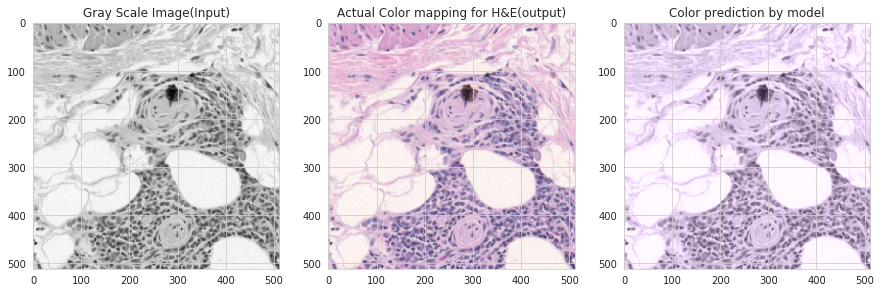

In [181]:
plt_predict(13,X_HE,data, myModel)

In [57]:
## Load H&E Images
### Resd in H&E Images
directory = "../datasets/MUSE/trainA"
extension = "jpg"
data_MUSE, data_gray_MUSE = load_from_dir(directory, extension)
print("Shape of data_gray is {}".format(data_gray.shape))
print("Shape of data is {}".format(data.shape))

X_MUSE = data_gray_MUSE[:,:,:,0]
m,n,o = X_MUSE.shape
X_MUSE = X_MUSE.reshape(m,n,o,1)



Shape of data_gray is (334, 512, 512, 3)
Shape of data is (334, 512, 512, 3)


ValueError: too many values to unpack (expected 3)

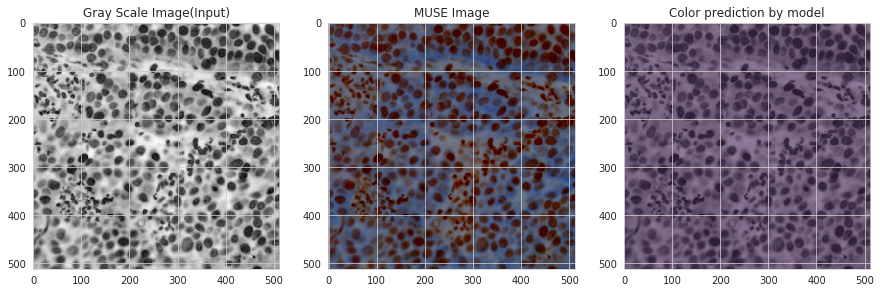

In [185]:
plt_predict(8,X_MUSE,data_MUSE,myModel,1)